# 0.0 IMPORTS


In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import math
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from datetime import datetime, timedelta
import datetime

## 0.1 HELP FUNCTIONS

In [25]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
sns.set()

In [26]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\wesle\anaconda3\envs\rossman\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 LOADING DATAS

In [2]:
df_store_raw = pd.read_csv('store.csv', low_memory = False)
df_sales_raw = pd.read_csv('train.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how= 'left',on= 'Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
770034,355,6,2013-08-10,7327,969,1,0,0,0,a,c,9720.0,8.0,2013.0,0,NaN,NaN,NaN


# 1.0 DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

# MAP é uma função que aplica outra função em cada item de uma lista
cols_new = list(map(snakecase,cols_old))

#rename

df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
print("number of rows: {}".format(df1.shape[0]))
print("number of columns: {}".format(df1.shape[1]))

number of rows: 1017209
number of columns: 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillna NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )
                                                                
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)
    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)
        

month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'oct',11:'Nov',12:'Dec'}  

df1['promo_interval'].fillna(0,inplace=True)    

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                            if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1 )

## 1.6 Change Type

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')          
df1['competition_open_since_year']= df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week']  = df1['promo2_since_week'].astype('int64')                    
df1['promo2_since_year']= df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float'])
cat_attributes = df1.select_dtypes(exclude= ['int64','float','datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [13]:
# central tendency - mean,median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T
# dispersion - sts, min, max, range, kurtosis, skew
d1= pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

metrica= pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrica.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
metrica

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1.0,2015.0,2014.0,1372.032482,2006.0,932.640284,-0.782151,-1.388100


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

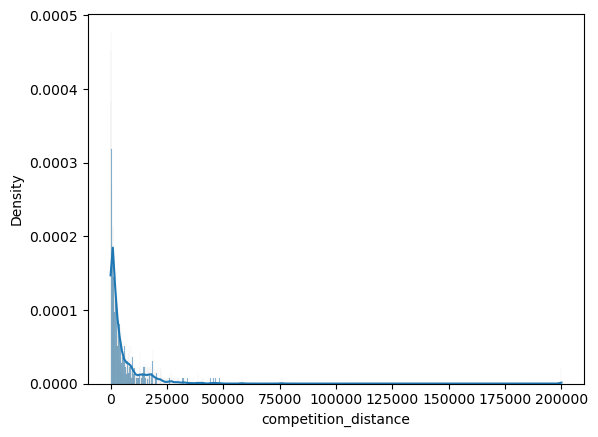

In [14]:
sns.histplot(df1['competition_distance'], kde=True, stat="density")

### 1.7.2 Categoric Atrributes

<AxesSubplot:xlabel='assortment', ylabel='sales'>

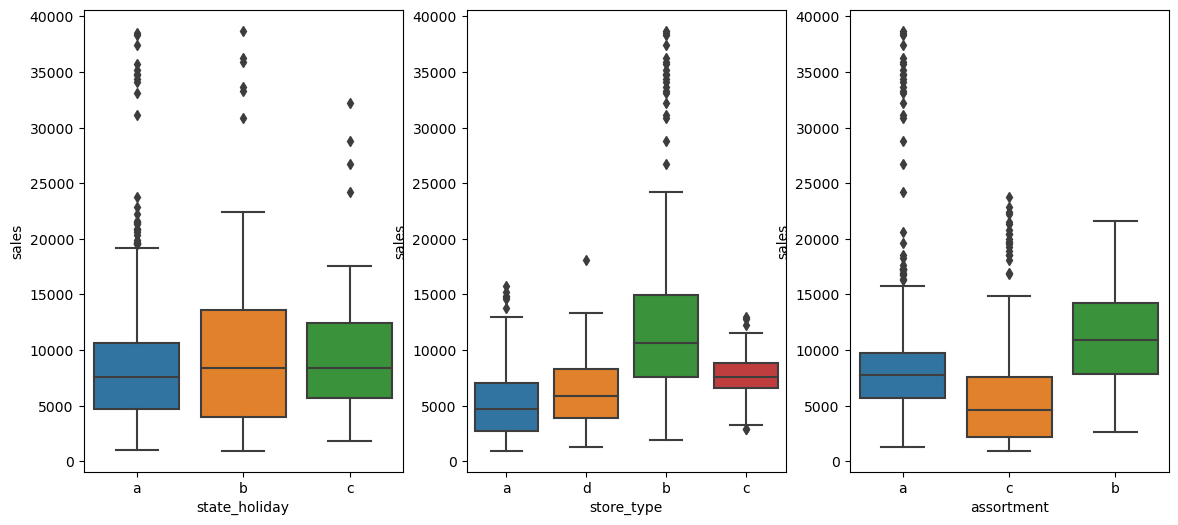

In [15]:
aux1= df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure (figsize = (14,6))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Enginnering


In [16]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

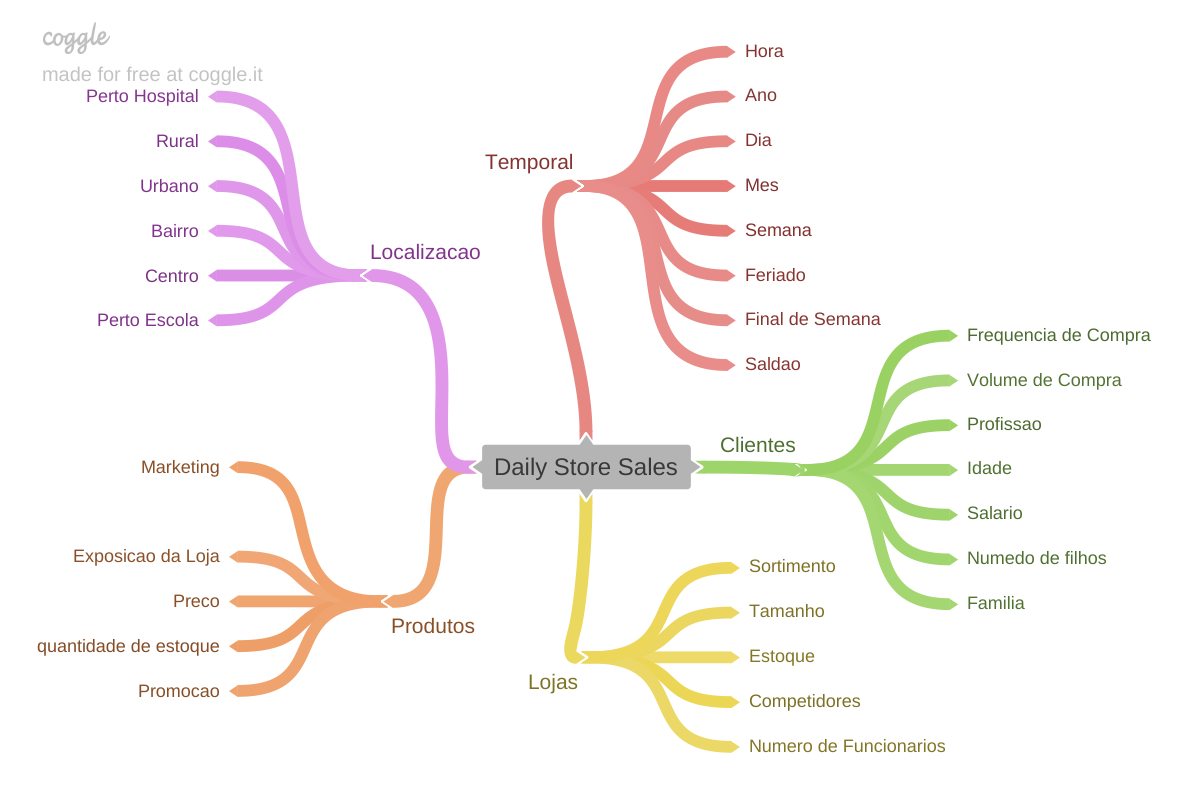

In [17]:
Image('mindmaphipoteses.png',width=700, height=100)

## 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

**7.** Lojas com competidores mais proximos deveriam vender menos.

## 2.1.2 Products Hypothesis 

**1.** Lojas que investe mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais produtos expostos na vitrine deveriam vender mais.

**3.** Lojas que tem precos menores em produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.

**5.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

**8.** Lojas com mais dias de promocoes deveriam vender mais.



## 2.1.2 Time Hypothesis 

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas que abrem durante o feriado de natal deveriam vender mais.

**5.** Lojas deveriam vender mais a cada ano.

**6.** Lojas deveriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**8.** Lojas deveriam vender menos nos finais de semana.

**9.** Lojas deveriam vender menos durante as ferias escolares.





## 2.2 Final List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores a mais tempo deveriam vender mais.

**3.** Lojas com competidores mais proximos deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promocoes consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promocoes deveriam vender mais.

**7.** Lojas que expoe mais produtos expostos na vitrine deveriam vender mais.

**8.** Lojas que tem precos menores em produtos deveriam vender mais.

**9.** Lojas que tem precos menores por mais tempo deveriam vender mais.

**10.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**11.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**12.** Lojas com mais promocoes consecutivas deveriam vender mais.

**13.** Lojas com mais dias de promocoes deveriam vender mais.



## 2.3 Feature Enginnering

In [18]:
df2['year']=df2['date'].dt.year
df2['month']=df2['date'].dt.month
df2['day']=df2['date'].dt.day
df2['week_of_year']=df2['date'].dt.weekofyear
df2['year_of_week']=df2['date'].dt.strftime('%Y-%W')

C:\Users\wesle\AppData\Local\Temp\ipykernel_16116\241576499.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.weekofyear


In [40]:
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'],day=1),axis = 1)
df2['competition_since'] = pd.to_datetime(df2['competition_since'], errors = 'coerce')
df2.dropna(inplace=True)
df2['competition_time_month']= ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%M-%w') - datetime.timedelta(days=7))
df2['promo_time_week']= ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortments
df2['assortments']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

#state_holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

KeyboardInterrupt: 

In [43]:
df2.head(3).T

,0,1,2
store,1,2,3
day_of_week,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314
customers,555,625,821
open,1,1,1
promo,1,1,1
state_holiday,regular_day,regular_day,regular_day
school_holiday,1,1,1
store_type,c,a,a
